## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [119]:
# !pip install pandarallel

In [60]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

import re
from pandarallel import pandarallel
from wordcloud import WordCloud, STOPWORDS
from nltk import ngrams
from collections import Counter

pandarallel.initialize(progress_bar=False)
pd.set_option('max_columns', 50)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [3]:
#Check dataframe
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#Lets check dataframe size
'''
Total 78213 records are there in dataset
'''
df.shape

(78313, 22)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
'''
Columns like _source.tags ,_source.zip_code , _source.company_public_response , _source.sub_product, _source.sub_issue ,
_source.consumer_consent_provided has some missing values.

But we need to check single or more spaces as well which is not treated as missing by df.info()
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names

pprint(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [7]:
#Assign new column names

df.columns = [clm.replace('_','',1).replace('source.','') for clm in df.columns]

print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [8]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened']=='']=np.nan

In [9]:
#Ensuring there are no more blank values
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided


In [10]:
df.shape

(78313, 22)

In [11]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

In [12]:
df.reset_index(inplace=True,drop=True)

In [13]:
'''
After removing eampty complain we have total 21072 complain for topic modelling.
'''
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Typecasting the required column
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(sent):
    sent=sent.lower() # Text to lowercase
    sent = re.sub('[^\w\s]', '', sent) # Removing punctuation
    sent = re.sub('\w*\d\w*', '', sent) # Removing words with numbers in between
    return sent

df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [16]:
df_clean.head()

,complaint_what_happened
0,good morning my name is xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in and was told ...
2,chase card was reported on however fraudulent...
3,on while trying to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...


In [17]:
#Write your function to Lemmatize the texts
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].parallel_apply(lemmmatize_text)

In [19]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [20]:
#Write your function to extract the POS tags 

def pos_tag(text):
    # write your code here
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.tag_=='NN'])
            
df_clean["complaint_POS_removed"] =  df_clean['complaint_lemmatized'].parallel_apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade anniversary date agent info...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




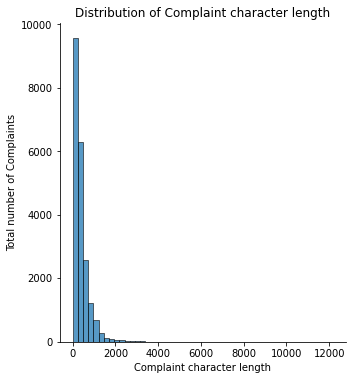

In [22]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=50)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

### ***🔑 Note***: The distribution is a bit skewed to the left with a large tail on one side. Overall, nothing abnormal observed

#### Find the top 40 words by frequency among all the articles after processing the text.

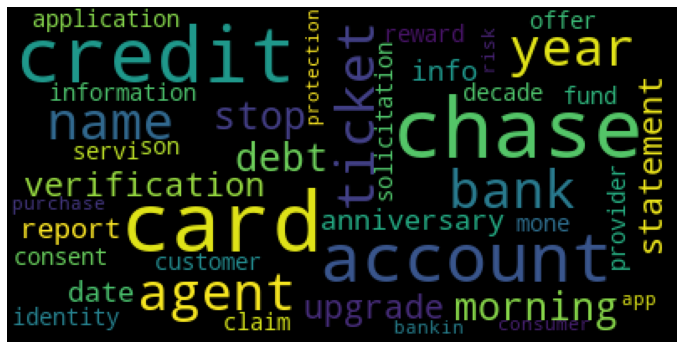

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=50, max_words=40, random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [24]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [25]:
def extract_top_ngrams(text_data, top=10, ngram=1):
    # Retrieve the text data from the specified column
    text_data = text_data.tolist()
    
    # Concatenate all text data into a single string
    text = ' '.join(text_data)
    
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    
    # Generate n-grams based on the specified n-gram type
    grams = ngrams(words, ngram)
    
    # Count the occurrences of each n-gram
    ngram_counts = Counter(grams)
    
    # Extract the top n most frequent n-grams
    top_ngrams = ngram_counts.most_common(top)
    
    return top_ngrams

In [26]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_ngrams = extract_top_ngrams(df_clean['Complaint_clean'],top=30, ngram=1)
unigram_df = pd.DataFrame(top_ngrams,columns=['words','counts'])
unigram_df

,words,counts
0,"(account,)",46663
1,"(chase,)",34981
2,"(credit,)",32968
3,"(card,)",30027
4,"(payment,)",21044
5,"(bank,)",19073
6,"(time,)",15969
7,"(charge,)",14170
8,"(check,)",12821
9,"(day,)",12789


In [27]:
#Print the top 10 words in the unigram frequency
unigram_df.head(10)

,words,counts
0,"(account,)",46663
1,"(chase,)",34981
2,"(credit,)",32968
3,"(card,)",30027
4,"(payment,)",21044
5,"(bank,)",19073
6,"(time,)",15969
7,"(charge,)",14170
8,"(check,)",12821
9,"(day,)",12789


In [28]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_ngrams = extract_top_ngrams(df_clean['Complaint_clean'],top=30, ngram=2)
biagram_df = pd.DataFrame(top_ngrams,columns=['words','counts'])
biagram_df

,words,counts
0,"(credit, card)",12757
1,"(credit, report)",3824
2,"(customer, service)",3051
3,"(check, account)",2977
4,"(bank, account)",2355
5,"(account, account)",2319
6,"(account, chase)",2252
7,"(chase, credit)",2109
8,"(chase, account)",2040
9,"(debit, card)",1948


In [29]:
#Print the top 10 words in the bigram frequency
biagram_df.head(10)

,words,counts
0,"(credit, card)",12757
1,"(credit, report)",3824
2,"(customer, service)",3051
3,"(check, account)",2977
4,"(bank, account)",2355
5,"(account, account)",2319
6,"(account, chase)",2252
7,"(chase, credit)",2109
8,"(chase, account)",2040
9,"(debit, card)",1948


In [30]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_ngrams = extract_top_ngrams(df_clean['Complaint_clean'],top=30, ngram=3)
trigram_df = pd.DataFrame(top_ngrams,columns=['words','counts'])
trigram_df

,words,counts
0,"(chase, credit, card)",1552
1,"(credit, card, account)",1087
2,"(credit, card, company)",992
3,"(credit, card, credit)",542
4,"(credit, card, chase)",512
5,"(inquiry, credit, report)",506
6,"(account, credit, card)",497
7,"(card, credit, card)",442
8,"(charge, credit, card)",432
9,"(chase, check, account)",394


In [31]:
#Print the top 10 words in the trigram frequency
trigram_df.head(10)

,words,counts
0,"(chase, credit, card)",1552
1,"(credit, card, account)",1087
2,"(credit, card, company)",992
3,"(credit, card, credit)",542
4,"(credit, card, chase)",512
5,"(inquiry, credit, report)",506
6,"(account, credit, card)",497
7,"(card, credit, card)",442
8,"(charge, credit, card)",432
9,"(chase, check, account)",394


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [32]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [33]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,risk consumer chase bank app chase year bankin...,risk consumer chase bank app chase year bankin...
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card freedom problem b...,credit yrs chase credit card freedom problem b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [34]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [35]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [36]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [37]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [38]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6666

In [39]:
H = nmf_model.components_     # Topic-term matrix

In [40]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,deposit,chase,branch,day,number,business,transfer,transaction,customer,claim
Topic 2,card,credit,chase,balance,account,limit,score,year,point,month,purchase,offer,application,time,reason
Topic 3,payment,loan,mortgage,month,home,modification,chase,time,year,rate,balance,property,statement,date,day
Topic 4,report,inquiry,credit,information,company,reporting,debt,bureaus,account,identity,theft,score,file,letter,date
Topic 5,charge,dispute,transaction,fee,merchant,chase,claim,fraud,purchase,service,email,time,company,day,refund


**Observation**
Looking at the topics above, for each topic, we can give a label based on their products/services:

- Topic 1 = Bank account services
- Topic 2 = Credit card / Prepaid card
- Topic 3 = Mortgages/loans
- Topic 4 = Other
- Topic 5 = Theft/Dispute reporting

In [41]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)

In [42]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)#write your code to assign topics to each rows.

In [43]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,3
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [44]:
df_clean.shape

(21072, 5)

In [45]:
#Print the first 5 Complaint for each of the Topics
df_clean_topic=df_clean.groupby('Topic').head(5)
df_clean_topic.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
12,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account code bonus term everything account dep...,account code bonus term everything account dep...,0
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
15,i opened the saving account for the bonus i w...,I open the saving account for the bonus I be...,saving account bonus bonus auto transfer check...,saving account bonus bonus auto transfer check...,0
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account,mishandle account,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,1
22,my roommate was stealing my chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,1
21,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen company time share company nothing ref...,citizen company time share company nothing ref...,1
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,chase card decline catering order place brothe...,1
25,i currently have over xxxx chase ultimate rewa...,I currently have over xxxx chase ultimate rewa...,reward point month reward account bonus freedo...,reward point month reward account bonus freedo...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [46]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Mortgages/loans",
               3:"Others", 4:"Theft/Dispute reporting" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [47]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgages/loans
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,Credit card / Prepaid card
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Others
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Others
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank account services': 0, 'Credit card / Prepaid card': 1, 'Mortgages/loans': 2,
               'Others': 3, 'Theft/Dispute reporting': 4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [52]:
df_clean.shape

(21072, 5)

In [54]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [55]:
training_data.head()

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i apprec...,2
1,i upgraded my xxxx xxxx card in and was told ...,1
2,chase card was reported on however fraudulent...,3
3,on while trying to book a xxxx xxxx ticket ...,3
4,my grand son give me check for i deposit it i...,0


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [71]:
#Write your code to get the Vector count
vect = CountVectorizer()
X_cnt = vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_cnt)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Logistic Regression

In [78]:
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [73]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data['Topic'], test_size=0.30, random_state=42)

In [74]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [75]:
# Getting the score of the base model
logreg.score(X_test, y_test)

0.9035115469788042

#### HyperParameter Tuning

In [79]:
logreg_grid = {"C": [10, 4, 2, 1, 0.1, 0.01],
                "solver": ["liblinear", "lbfgs"]}

# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [10, 4, 2, 1, 0.1, 0.01],
                         'solver': ['liblinear', 'lbfgs']},
             verbose=True)

In [80]:
# Check best parameters
logreg_hpt.best_params_

{'C': 4, 'solver': 'lbfgs'}

In [81]:
# Evaluating the tuned model
logreg_hpt.score(X_test, y_test)

0.9134767478645998

In [82]:
# Make predictions on test data
y_pred = logreg_hpt.predict(X_test)

In [83]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1456   18   33   12   55]
 [  24 1138   14   15   61]
 [  21   16 1447   18   28]
 [  15   30   22  606   17]
 [  72   31   33   12 1128]]


In [84]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topic_names.keys()))
print('precision is as follows :',precision_score(y_test, y_pred, average='macro'))
print('recall is as follows :',recall_score(y_test, y_pred, average='macro'))

                            precision    recall  f1-score   support

     Bank account services       0.92      0.93      0.92      1574
Credit card / Prepaid card       0.92      0.91      0.92      1252
           Mortgages/loans       0.93      0.95      0.94      1530
                    Others       0.91      0.88      0.90       690
   Theft/Dispute reporting       0.88      0.88      0.88      1276

                  accuracy                           0.91      6322
                 macro avg       0.91      0.91      0.91      6322
              weighted avg       0.91      0.91      0.91      6322

precision is as follows : 0.9126207824920417
recall is as follows : 0.9084004991677638


- The overall accuracy of the Logistic Regression model is **91%**.
- Precision and Recall are 91% and 91% respectively which makes this is a very good model.

### Decision Tree Classifier

In [85]:
# Importing DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

In [86]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [87]:
# Getting the score of the base model
dt.score(X_test, y_test)

0.7619424232837709

#### HyperParameter Tuning

In [88]:
dt_grid = {'max_depth': [5, 10, 20, 40],
           'min_samples_leaf': [5, 10, 20, 50]}

In [89]:
# Setup grid hyperparameter search for LogisticRegression
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 40],
                         'min_samples_leaf': [5, 10, 20, 50]},
             verbose=True)

In [90]:
# Check best parameters
dt_hpt.best_params_

{'max_depth': 20, 'min_samples_leaf': 10}

In [91]:
# Evaluating the tuned model
dt_hpt.score(X_test, y_test)

0.7815564694716862

In [92]:
# Make predictions on test data
y_pred = dt_hpt.predict(X_test)

In [93]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1272   53   56   26  167]
 [  59  998   27   45  123]
 [  67   55 1259   41  108]
 [  35   82   48  487   38]
 [ 150  126   59   16  925]]


In [94]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topic_names.keys()))
print('precision is as follows :',precision_score(y_test, y_pred, average='macro'))
print('recall is as follows :',recall_score(y_test, y_pred, average='macro'))

                            precision    recall  f1-score   support

     Bank account services       0.80      0.81      0.81      1574
Credit card / Prepaid card       0.76      0.80      0.78      1252
           Mortgages/loans       0.87      0.82      0.85      1530
                    Others       0.79      0.71      0.75       690
   Theft/Dispute reporting       0.68      0.72      0.70      1276

                  accuracy                           0.78      6322
                 macro avg       0.78      0.77      0.78      6322
              weighted avg       0.78      0.78      0.78      6322

precision is as follows : 0.7806885695139039
recall is as follows : 0.7717702593141864


- The overall accuracy of the Decision Tree model is **78%**
- Precision and Recall are 78% and 71% respectively

### Random Forest Classifier 

In [95]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

In [96]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [97]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.8128756722556153

#### HyperParameter Tuning 

In [98]:
rf_grid = {'max_depth': [5, 10, 15],
           'min_samples_leaf': [2, 10],
           'n_estimators': [200, 300, 400]}

In [99]:
# Setup grid hyperparameter search for LogisticRegression
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'min_samples_leaf': [2, 10],
                         'n_estimators': [200, 300, 400]},
             verbose=True)

In [100]:
# Check best parameters
rf_hpt.best_params_

{'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 400}

In [101]:
# Evaluating the tuned model
rf_hpt.score(X_test, y_test)

0.7700094906675102

In [102]:
# Make predictions on test data
y_pred = rf.predict(X_test)

In [103]:
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1421   36   65    6   46]
 [ 107  951   44   24  126]
 [  63   55 1378    6   28]
 [  50   90   86  450   14]
 [ 184   61   74   18  939]]


In [105]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topic_names.keys()))
print('precision is as follows :',precision_score(y_test, y_pred, average='macro'))
print('recall is as follows :',recall_score(y_test, y_pred, average='macro'))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.90      0.84      1574
Credit card / Prepaid card       0.80      0.76      0.78      1252
           Mortgages/loans       0.84      0.90      0.87      1530
                    Others       0.89      0.65      0.75       690
   Theft/Dispute reporting       0.81      0.74      0.77      1276

                  accuracy                           0.81      6322
                 macro avg       0.82      0.79      0.80      6322
              weighted avg       0.82      0.81      0.81      6322

precision is as follows : 0.8239414569396143
recall is as follows : 0.7902202029892902


- The overall accuracy of the Random Forest model is **81%**
- Precision and Recall are 83% and 79% respectively and we can see that the model overfits for "Others" category for Precision

### Summary

In [106]:
# Creating a dataframe to summarise the results of each model.
summary_df = pd.DataFrame({"Test Accuracy":[logreg_hpt.score(X_test, y_test),dt_hpt.score(X_test, y_test),rf.score(X_test, y_test)]}, 
                      index = ['Logistic Regression','Decision Tree Classifier',"Random Forest Classifier"])

summary_df.head()

,Test Accuracy
Logistic Regression,0.913477
Decision Tree Classifier,0.781556
Random Forest Classifier,0.812876


- We can infer that logistic regression model is able to perform the best for our use case
- The best model has an accuracy of **91%** with Precision and Recall as **91%** and **91%** respectively